<p style="padding: 10px; border: 1px solid black;">
<img src="images/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>


# <a name="0">MLU LangChain Workshop </a>
## <a name="0">Lab 2: Memory and Chains </a>

This notebook demonstrates the use of memory and chains to build applications powered by LLMs. 
    Adding memory allows the context to persist across multiple sessions. This is particularly useful in conversational applications such as chatbots, where the system is required to follow the conversation by recalling past interactions.
    An isolated LLM is quite capable in solving a diverse range of tasks. However, the complexity of the application's capabilities can be enhanced significantly by chaining multiple LLMs together. A chain parses a sequence of calls to various components which can include other chains.


1. <a href="#1">Import libraries</a>
2. <a href="#2">Define the Bedrock Model for Inference</a>
3. <a href="#3">Simple Chains</a>
4. <a href="#4">Memory</a>
    - <a href="#4.1">Simple Memory</a>
    - <a href="#4.2">Conversational Buffer Memory</a>
    - <a href="#4.3">Conversational Summary Buffer Memory</a>
5. <a href="#5">Chains</a>
    - <a href="#5.1">Sequential Chains with a Single Input</a>
    - <a href="#5.2">Sequential Chains with Multiple Input</a>
    - <a href="#5.3">Router Chains</a>
6. <a href="#6">LLM Applications with Chains</a>
7. <a href="#7">Quizzes</a>


    
Please work top to bottom of this notebook and don't skip sections as this could lead to error messages due to missing code.

---

You will be presented with two kinds of exercises throughout the notebook: activities and challenges. <br/>

| <img style="float: center;" src="./images/activity.png" alt="Activity" width="125"/>| <img style="float: center;" src="./images/challenge.png" alt="Challenge" width="125"/>|
| --- | --- |
|<p style="text-align:center;">No coding is needed for an activity. You try to understand a concept, <br/>answer questions, or run a code cell.</p> |<p style="text-align:center;">Challenges are where you test your understanding by taking a short quiz.</p> |

----    


Let's start by loading some libraries and packages!

---

### <a name="1">Import libraries</a>
(<a href="#0">Go to top</a>)


First, let's install and import the necessary libraries, including the Hugging Face Transformers library and the PyTorch library, which is a dependency for Transformers.


In [1]:
%%capture
!pip3 install -r requirements.txt --quiet

In [2]:
import boto3
import json
import pandas as pd
from IPython.display import Markdown

import warnings

warnings.filterwarnings("ignore")

### <a name="#2">Define the Bedrock Model for Inference</a>
(<a href="#0">Go to top</a>)

Let's select the Bedrock model the same way we did in the previous lab.

**Please opt for frugal practices when using Bedrock such as using smaller LLMs for simpler tasks and only reserving the use of the larger LLMs for more complex use cases.**

In [3]:
from langchain_aws import BedrockLLM
from mlu_utils.helpers import validate_inference_parameters

# Define the bedrock client
bedrock = boto3.client(
    service_name="bedrock",
    region_name="us-east-1",
    endpoint_url="https://bedrock.us-east-1.amazonaws.com",
)

# Define the bedrock-runtime client that will be used for predictions
bedrock_runtime = boto3.client(service_name="bedrock-runtime")


##########################################################################
########################### Select the LLM ###############################

# bedrock_model_id = "amazon.titan-text-premier-v1:0"
bedrock_model_id = "mistral.mixtral-8x7b-instruct-v0:1"

##########################################################################
##########################################################################

# Each model has a different set of inference parameters
inference_modifier = {
    "max_tokens": 4096,
    "temperature": 0.0,
    "top_p": 1,
}

# Sanity check for the inference parameters
validate_inference_parameters(
    model_id=bedrock_model_id, inference_parameters=inference_modifier
)

# Define the langchain module with the selected bedrock model
bedrock_llm = BedrockLLM(
    model_id=bedrock_model_id, client=bedrock_runtime, model_kwargs=inference_modifier
)

### <a name="#3">Simple Chains</a>
(<a href="#0">Go to top</a>)

---
The LLMChain is most basic building block chain. It takes in a prompt template, formats it with the user input and returns the response from an LLM.

<div>
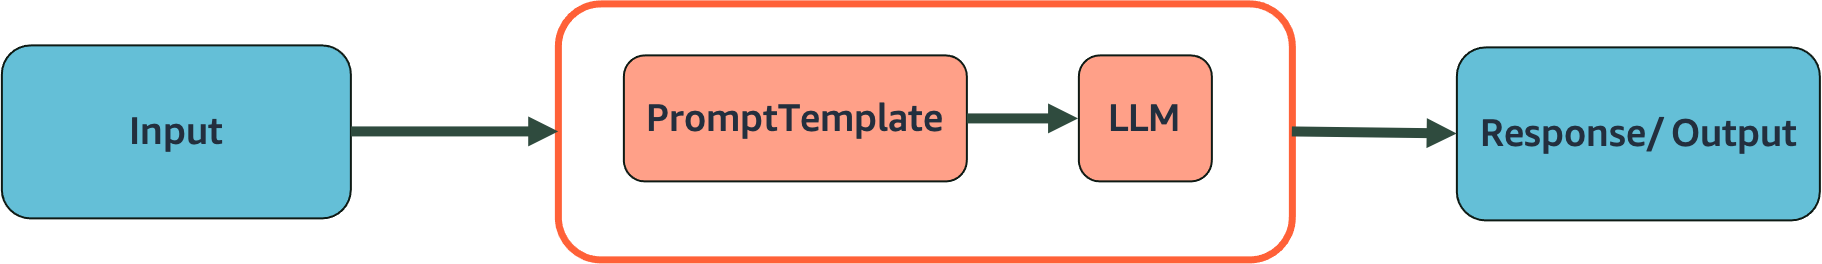
</div>

Let's use a prompt template from the lab and embed it into a simple chain.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="./images/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Try different prompts throughout the notebook and observe the responses generated by the chains.</p>
    <p style=" text-align: center; margin: auto;"><b>Note: Results may not be factually accurate and may be based on false assumptions.</b></p>
    <br>
</div>


In [4]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

warnings.filterwarnings("ignore")


template = """
You are an event manager. Given the type of event, time and location, write an invitation for the event. 
Use a 
Event: {event}
Time: {time}
Location: {location}
"""

# Define the prompt template from the string. The input variables are automatically inferred
prompt_template = PromptTemplate.from_template(template)


# Define the simple chain with the LLM and the prompt template
chain = LLMChain(llm=bedrock_llm, prompt=prompt_template)

# Use the LLMChain to generate responses
chain_response = chain.run(
    {
        "event": "birthday",
        "time": "December 17th, 8pm EST",
        "location": "Bryant Park, New York",
    }
)

# Printing the response in a favorable format
Markdown(chain_response)


Dear Friends and Family,

You are cordially invited to join us in celebrating the birthday of [Name] on December 17th at 8pm EST in Bryant Park, New York.

It's going to be a night filled with love, laughter, and joy as we gather to honor and celebrate the life of our dear [Name]. We have planned a special evening filled with fun activities, delicious food, and great company.

Please come dressed warmly and ready to have a great time. We encourage you to bring a small gift to help us make [Name]'s birthday extra special.

We look forward to seeing you there!

Best regards,

[Your Name]
Event Manager

### <a name="#4">Memory</a>
(<a href="#0">Go to top</a>)

The memory component of LangChain allows the LLM to become 'stateful'. This quality is quite useful when developing applications driven by LLMs. For instance, a conversational system or a chatbot is required to recall past interactions to maintain a conversation. Without memory, the system would not be able to handle follow-up messages or recollect key pieces of information mentioned earlier in the conversation. 

In this section, we will explore the memory modules provided by LangChain. LangChain offers several types of memory modules depending on the task and the properties of the LLM. We will incorporate memory into chains and examine changes in performance due to it.

<div>
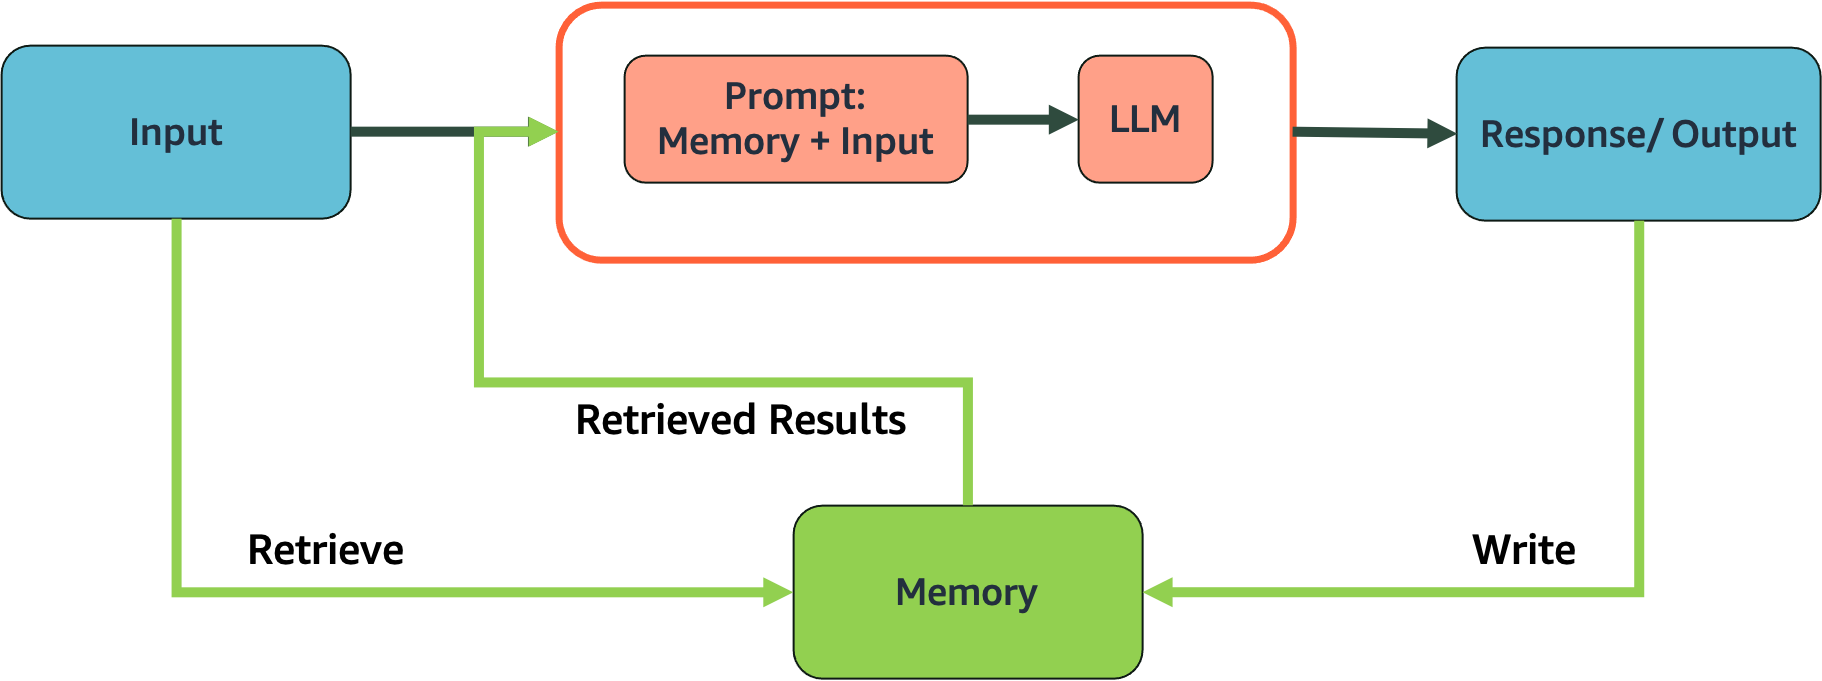
</div>

---

Let's define a helper function that takes a sequence of prompts in a list and a chain with a memory component. The function will sequentially prompt the chain with the given prompts and create a dataframe showing how the memory updates with each prompt.

In [5]:
def prompt_and_print_memory(prompts, chain_with_memory):
    # Store the responses
    responses = {"input": [], "history": [], "response": []}

    # Repeatedly prompting the chain and observing the memory
    for prompt in prompts:
        response = chain_with_memory(prompt)
        for key in response:
            responses[key].append(response[key])

    # Store and print the responses in a dataframe
    df = pd.DataFrame.from_dict(responses)
    with pd.option_context("display.max_colwidth", None):
        display(df)

---

#### <a name="4.2">Conversational Buffer Memory</a>
(<a href="#0">Go to top</a>)

`ConversationalBufferMemory` is suitable for conversations. `ConversationalBufferMemory` maintains the interactions between the Human and AI and can recall past interactins to augment the context of a prompt.

In this example, we will be using `ConversationChain` using a `ConversationBufferMemory` and observing how the memory buffer updates after a few interactions. The `ConversationChain` extends the `LLMChain` and is used to conduct conversation between a Human and an AI.

In [6]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

warnings.filterwarnings("ignore")

cbm_memory = ConversationBufferMemory()

# Adding memory to a conversational chain
chain_with_buffer_memory = ConversationChain(llm=bedrock_llm, memory=cbm_memory)

# Sequence of prompts for the ConversationChain
cbm_prompts = [
    "What is Amazon Sagemaker?",
    "Can it help with deploying ML models?",
    "Do you need an AWS account to access it?",
]

# Use the helper function defined to sequentially prompt the chain and observe the memory buffer with each prompt
prompt_and_print_memory(cbm_prompts, chain_with_buffer_memory)

input  \
0                 What is Amazon Sagemaker?   
1     Can it help with deploying ML models?   
2  Do you need an AWS account to access it?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

#### <a name="4.3">Conversational Summary Buffer Memory</a>
(<a href="#0">Go to top</a>)

`ConversationalSummaryBufferMemory` combines the concept of `ConversationalBufferMemory` and `ConversationSummaryMemory`. 
It uses an LLM to compile old conversations into a summary as well as maintaining a buffer of the most recent interactions. This type of memory is particularly useful if you want to use LLMs to generate long paragraphs while still preserving relecant information for follow-up questions. This kind of memory is also suitable for scenarios where the conversation is expected to be very long.

In this example, we use an LLM to generate an essay and as it to perform some follow-up tasks.

In [7]:
from langchain.memory import ConversationSummaryBufferMemory

warnings.filterwarnings("ignore")

# Defining the ConversationalSummaryBufferMemory
summary_buffer_memory = ConversationSummaryBufferMemory(
    llm=bedrock_llm, max_token_limit=100
)

# Adding ConversationalSummaryBufferMemory to a ConversationChain
chain_with_summary_memory = ConversationChain(
    llm=bedrock_llm, memory=summary_buffer_memory
)

# Sequence of prompts for the ConversationChain
csm_prompts = [
    "Write an article about feminism.",
    "How does it affect our society?",
    "Does the article talk about inequality in pay?",
]

# Use the helper function defined to sequentially prompt the chain and observe the memory buffer with each prompt
prompt_and_print_memory(csm_prompts, chain_with_summary_memory)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

,input,history,response
0,Write an article about feminism.,,"Sure, I'd be happy to help you with that! Feminism is a range of social movements, political movements, and ideologies that share a common goal: to define, establish, and achieve political, economic, personal, and social equality of sexes. This includes seeking to establish educational and professional opportunities for women that are equal to those for men.\n\nThe term ""feminism"" is derived from the French word ""femme,"" which means ""woman."" Feminism is often associated with the fight for women's rights, but it is much more than that. It is about challenging stereotypes and discrimination, and advocating for equal opportunities and rights for all, regardless of gender.\n\nThere are different types of feminism, including liberal feminism, radical feminism, socialist feminism, and intersectional feminism. Each type has its own unique perspective and approach to achieving gender equality.\n\nLiberal feminism, for example, focuses on achieving gender equality through legal and political reforms. Radical feminism, on the other hand, argues that the root of women's oppression is the patriarchal system, and seeks to overthrow this system. Socialist feminism, as the name suggests, sees the struggle for gender equality as linked to the struggle against capitalism and economic exploitation. Intersectional feminism, meanwhile, recognizes that gender inequality intersects with other forms of inequality, such as race, class, and sexuality, and seeks to address all of these forms of inequality simultaneously.\n\nFeminism has made significant contributions to society. It has helped to challenge and change discriminatory laws and practices, and has paved the way for women to have greater access to education, employment, and political power. However, there is still much work to be done. Women around the world continue to face discrimination and inequality in many areas of life, from education and employment to health and safety.\n\nIn conclusion, feminism is a complex and multifaceted movement that seeks to achieve gender equality in all areas of life. It is about challenging stereotypes, discrimination, and inequality, and advocating for equal opportunities and rights for all, regardless of gender.\n\nI hope this article provides a good introduction to feminism. If you have any questions or would like to know more, please don't hesitate to ask!"
1,How does it affect our society?,"System: \nThe human asks the AI to write an article about feminism. The AI writes an article about feminism, explaining that it is a range of social movements, political movements, and ideologies that share a common goal: to define, establish, and achieve political, economic, personal, and social equality of sexes. The AI explains that there are different types of feminism, including liberal feminism, radical feminism, socialist feminism, and intersectional feminism, each with its own unique perspective and approach to achieving gender equality. The AI concludes by stating that feminism has made significant contributions to society, but there is still much work to be done to achieve gender equality in all areas of life.","Feminism has had a profound impact on our society in many ways. For example, it has helped to challenge and change traditional gender roles and stereotypes, leading to greater opportunities and freedoms for both men and women. Feminism has also played a key role in advocating for and achieving legal and political rights for women, such as the right to vote, to own property, and to have control over their own bodies.\n\nFeminism has also brought attention to and challenged various forms of discrimination and inequality that women face, such as the gender pay gap, sexual harassment, and domestic violence. By raising awareness and advocating for change, feminism has helped to create more inclusive and equitable societies.\n\nMoreover, feminism has inspired and contributed to other socia

---

### <a name="#5">Chains</a>
(<a href="#0">Go to top</a>)

In this section, we will use chains to combine components of LangChain to improve the capabilities of the system.

---

#### <a name="5.1">Sequential Chains with a Single Input</a>
(<a href="#0">Go to top</a>)

Sequential chains allow to make a series of consecutive calls to the LLM. The simplest form of sequential chain is the `SimpleSequentialChain`. `SimpleSequentialChain` allows the output of one chain to go into the next subsequent chain. Since `SimpleSequentialChains` only consider one input and one output from each chain, you do not require to specify the input keys.
We will explore this in the next section when dealing with multiple inputs in sequential chains.

<div>
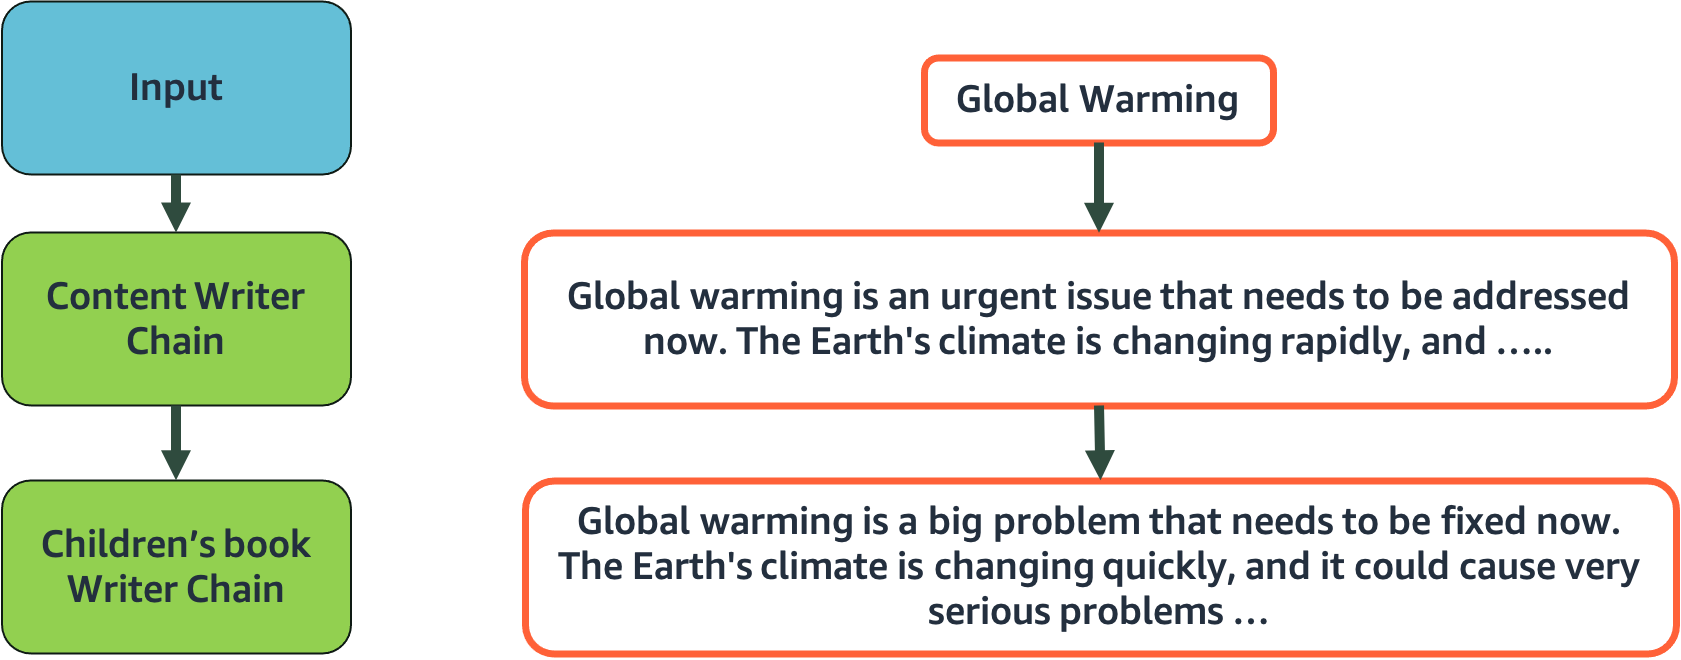
</div>

---

In [8]:
from langchain.chains import LLMChain, SimpleSequentialChain, SequentialChain

warnings.filterwarnings("ignore")

# The first prompt for the SimpleSequentialChain
content_writer_prompt = PromptTemplate.from_template(
    """
You are a content writer. Write an article about the following topic.
Topic: {topic}
Article:
"""
)

# The second prompt for the SimpleSequentialChain
children_book_author_prompt = PromptTemplate.from_template(
    """
Rewrite the following article such that a five year old can understand.
Article: {article}
Article that a five year old can understand:
"""
)

# Define LLMChains for each prompt template
content_writer_chain = LLMChain(llm=bedrock_llm, prompt=content_writer_prompt)
children_book_author_chain = LLMChain(
    llm=bedrock_llm, prompt=children_book_author_prompt
)

# Combine the two chains using the SimpleSequentialChain
combined_chain = SimpleSequentialChain(
    chains=[content_writer_chain, children_book_author_chain], verbose=True
)

# Run the SimpleSequentialChain
combined_chain.run("global warming")



> Entering new SimpleSequentialChain chain...
Global warming is a pressing issue that affects us all. It refers to the long-term increase in Earth's average temperature. While the Earth's climate has fluctuated in the past, the rapid warming seen today cannot be explained by natural processes alone. Instead, it is largely driven by human activities, such as the burning of fossil fuels and deforestation.

The burning of fossil fuels, such as coal, oil, and gas, releases large amounts of carbon dioxide (CO2) and other greenhouse gases into the atmosphere. These gases trap heat from the sun, causing the Earth's temperature to rise. Deforestation also contributes to global warming, as trees absorb CO2 and help to regulate the climate. When forests are cut down, not only is this important source of CO2 absorption lost, but the carbon stored in the trees is released into the atmosphere, further exacerbating the problem.

The effects of global warming are far-reaching and devastating. Risin

"Global warming is when the Earth gets too hot. It happens because we burn things like coal, oil, and gas for our cars and electricity, and that makes a gas called carbon dioxide that traps heat in the air. Trees help to keep the air clean by taking in carbon dioxide, but when we cut down too many trees, they can't help as much.\n\nWhen the Earth gets too hot, bad things happen. The ice at the North and South Poles melts and makes the sea level rise, which can flood homes and places where animals live. It also gets so hot that some animals and plants can't live there anymore.\n\nWe can help by using clean energy like the sun and the wind instead of burning things that make carbon dioxide. We can also plant more trees to help keep the air clean.\n\nGrown-ups can help too by making rules to use less carbon dioxide and by building things that use clean energy. We can all do our part to help keep the Earth cool and safe for everyone."

--- 

#### <a name="5.2">Sequential Chains with Multiple Inputs</a>
(<a href="#0">Go to top</a>)

In the above example, we used a `SimpleSequentialChain` which only took one input and one output. We can also make this more complex by allowing a chain to take multiple inputs and pass along multiple outpus. For the next example, we will use `SequentialChain`. 
When dealing with multiple inputs and outputs, it is important to name the input and output keys for each chain.

<div>
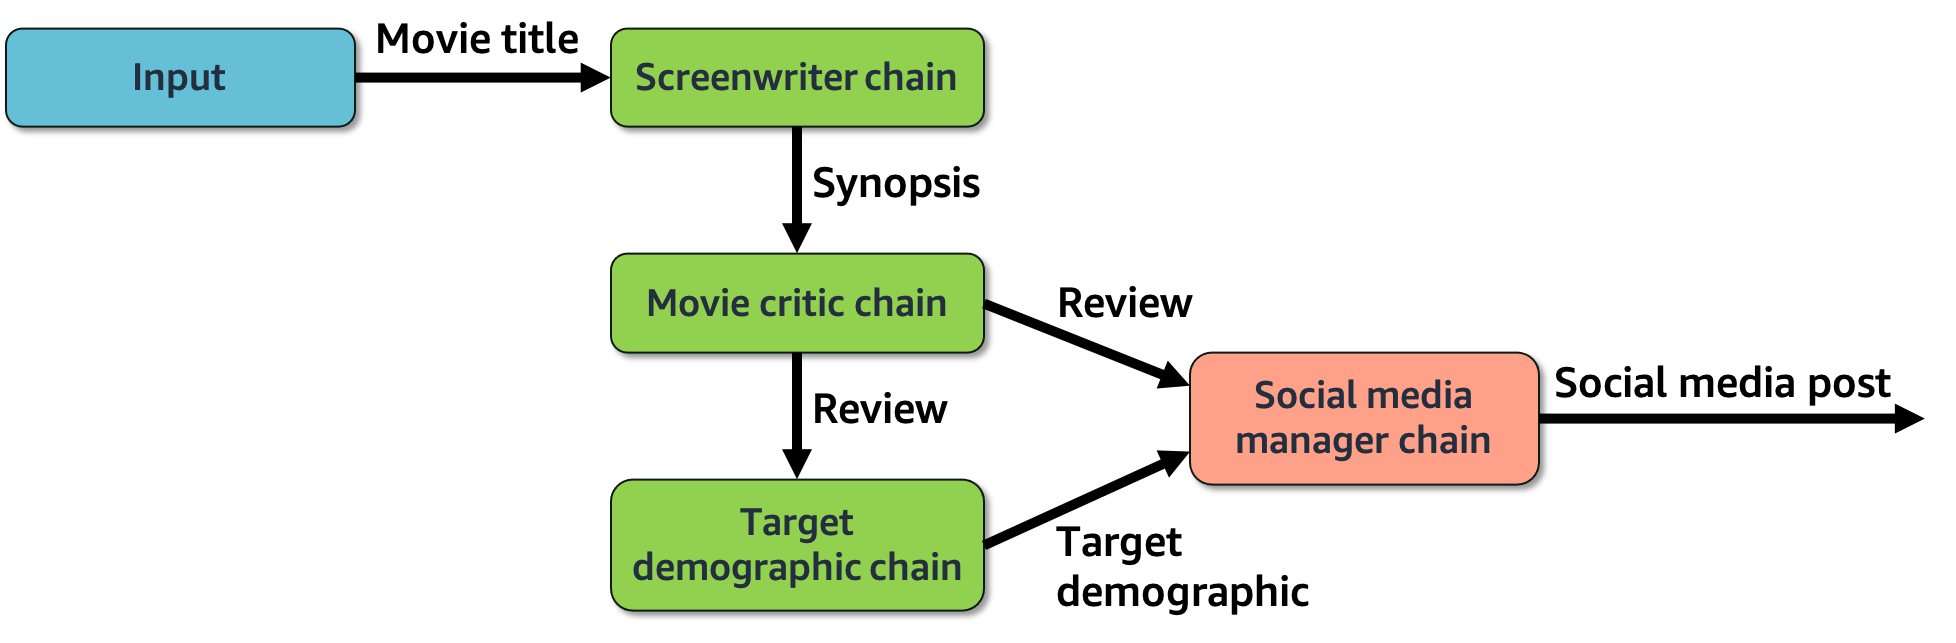
</div>

In [9]:
from langchain.chains import SequentialChain

warnings.filterwarnings("ignore")

# The first prompt for the SequentialChain
screenwriter_prompt = PromptTemplate.from_template(
    """
You are a screenwriter. Given the title of the movie, it is your job to write a synopsis for that movie. 
Title: {title}
Screenwriter: This is the synopsis of the above movie:
"""
)

# The second prompt for the SequentialChain
movie_critic_prompt = PromptTemplate.from_template(
    """
You are a movie critic from IMDB. Given the synopsis of the movie, it is your job to write a review of that movie. Be precise.
Synopsis: {synopsis}
Review from a IMDB movie critic:
"""
)

# The third prompt for the SequentialChain
target_demographic_prompt = PromptTemplate.from_template(
    """
Based on the critic review, suggest the target demographic for the movie. Be precise.
Critic Review: {review}
Target demographics:
"""
)

# The fourth prompt for the SequentialChain
social_media_manager_prompt = PromptTemplate.from_template(
    """
You are a social media manager for a production company. You need to write a short social media post that appeals to the given target demographic given the movie critic review.
The social media post should mention the rating if it is more than three.
Target demographic: {target_demographic}
Critic review: {review}
Social media manager: This is the social media post:
"""
)

# Define LLMChains for each prompt template
screenwriter_chain = LLMChain(
    llm=bedrock_llm, prompt=screenwriter_prompt, output_key="synopsis"
)
movie_critic_chain = LLMChain(
    llm=bedrock_llm, prompt=movie_critic_prompt, output_key="review"
)
target_demographic_chain = LLMChain(
    llm=bedrock_llm,
    prompt=target_demographic_prompt,
    output_key="target_demographic",
)
social_media_manager_chain = LLMChain(
    llm=bedrock_llm,
    prompt=social_media_manager_prompt,
    output_key="social_media_post",
)

# Combine the four chains using the SequentialChain
combined_sequential_chain = SequentialChain(
    chains=[
        screenwriter_chain,
        movie_critic_chain,
        target_demographic_chain,
        social_media_manager_chain,
    ],
    input_variables=["title"],
    output_variables=["synopsis", "review", "target_demographic", "social_media_post"],
    verbose=True,
)

# Run the SequentialChain
sequential_chain_response = combined_sequential_chain("Godfather")

# Format the responses in a dataframe and print
with pd.option_context("display.max_colwidth", None):
    display(pd.DataFrame.from_dict(sequential_chain_response, orient="index"))



> Entering new SequentialChain chain...

> Finished chain.


,0
title,Godfather
synopsis,"The Godfather is a classic American crime film directed by Francis Ford Coppola and based on the novel of the same name by Mario Puzo. The film follows the story of the Corleone family, a powerful Italian-American Mafia clan led by the patriarch, Vito Corleone (Marlon Brando).\nThe film begins with the wedding of Vito's daughter, Connie (Talia Shire), and introduces the viewer to the various members of the Corleone family, including Vito's sons, Sonny (James Caan), Fredo (John Cazale), and Michael (Al Pacino), as well as his adopted son, Tom Hagen (Robert Duvall).\nAs the family gathers to celebrate the wedding, Vito is approached by a rival Mafia family who wants him to use his influence to secure a deal for their son to enter the film industry. Vito refuses, and tensions between the two families begin to rise.\nMeanwhile, Michael, who has tried to distance himself from the family business, is drawn back in after an assassination attempt is made on his father's life. Michael takes charge of the family and begins to consolidate their power, eliminating their rivals and expanding their criminal empire.\nAs Michael becomes more ruthless and powerful, he alienates those closest to him, including his wife, Kay (Diane Keaton), and his sister, Connie. The film ends with Michael taking his place as the head of the Corleone family, having become the very thing he once despised.\nThe Godfather is a sweeping epic that explores themes of power, loyalty, and family. It is a masterful portrayal of the Mafia underworld and a classic of American cinema."
review,"The Godfather is a masterpiece of American cinema that has stood the test of time. Directed by Francis Ford Coppola and based on the novel by Mario Puzo, the film is a sweeping epic that explores themes of power, loyalty, and family.\nAt the heart of the film is the Corleone family, a powerful Italian-American Mafia clan led by the patriarch, Vito Corleone (Marlon Brando). Brando's portrayal of Vito is iconic, capturing the character's complexity and humanity. He is a loving father and husband, but also a ruthless and cunning mob boss.\nThe film's ensemble cast is equally impressive, with standout performances from James Caan as the hot-headed Sonny, John Cazale as the weak-willed Fredo, and Robert Duvall as the loyal Tom Hagen. However, it is Al Pacino's portrayal of Michael Corleone that truly steals the show. Michael's transformation from war hero to ruthless mob boss is both chilling and captivating, and Pacino's performance is nothing short of brilliant.\nThe film's plot is expertly crafted, with tension building steadily throughout. The wedding scene that opens the film is a masterclass in character introduction and world-building, and the assassination attempt on Vito is a heart-pounding moment that sets the stage for the rest of the film.\nThe Godfather is also a visual feast, with stunning cinematography and production design that bring the world of the Mafia to life. From the dark and moody interiors of the Corleone compound to the bustling streets of New York City, every frame is a work of art.\nIn conclusion, The Godfather is a must-see film for any fan of American cinema. Its complex characters, gripping plot, and stunning visuals make it a timeless classic that will continue to be watched and admired for generations to come."
target_demographic,1. Cinephiles and film enthusiasts who appreciate classic American cinema and masterful storytelling.\n2. Fans of crime dramas and mob movies who are interested in the inner workings of the Mafia.\n3. Viewers who enjoy character-driven narratives with complex and nuanced performances.\n4. Individuals who are interested in Italian-American culture and history.\n5. People who enjoy watching films with stunning cinematography and production design.\n6. Ages 18 and up due to mature themes and violence.
social_media_post,"🚨🎬 Cinephiles and film enthusiasts, unite! 🎬🚨\nThe Godfather, a masterpiece of Americ

--- 

#### <a name="5.3">Router Chains</a>
(<a href="#0">Go to top</a>)

In the examples we covered so far, we have been explicitly directing the sequence of calls by combining `LLMChains` in an ordered way. We can also implement techniques that enable a chain to dynamically select the next chain based on the type of input. These chains are called `LLMRouterChain`. `LLMRouterChain` use destination chains that the `LLMRouterChain` can route to.

In this example, we will use `LLMRouterChain` to direct the flow of towards the right prompt template. We will use three destination chains: the physics chain, the poem chain and the history chain. The `LLMRouterChain` uses an LLM to decide which chain to route to based on their description/summary.

<div>
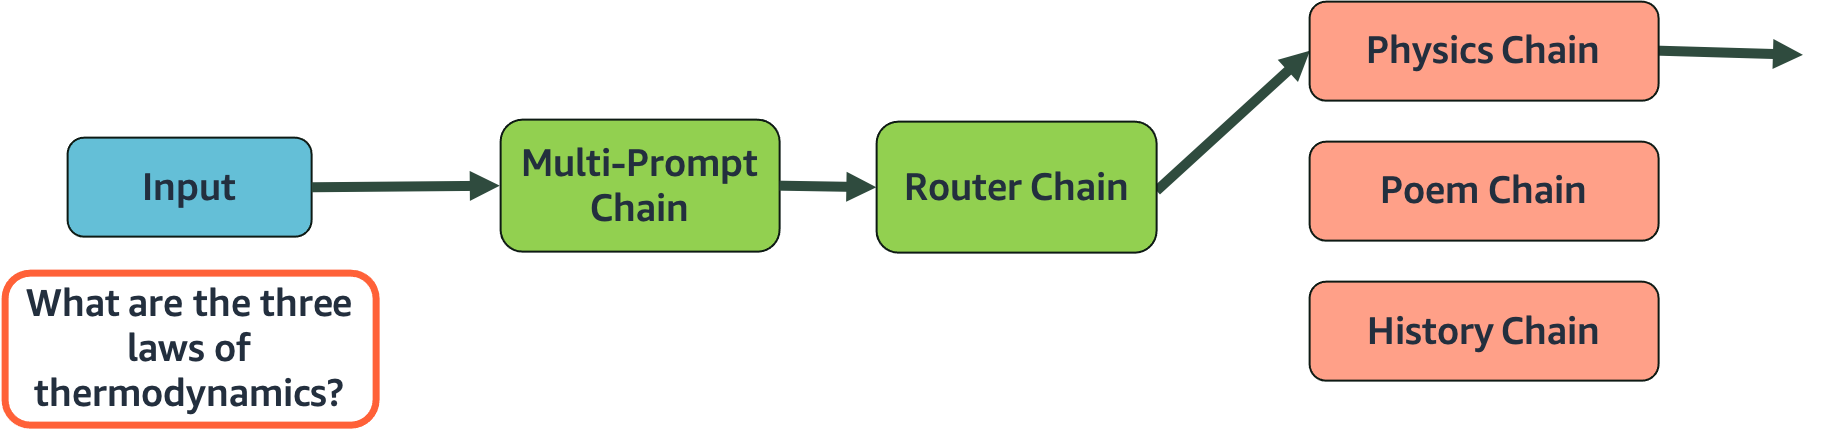
</div>

---

In [10]:
# Physics template used for answering questions about physics
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know. Be precise.

Here is a question:
{input}"""

# Poem template used for writing poems as per asked
poem_template = """You are a very good poet. You are skilled at writing short poems on a given topic.

Here is a statement:
{input}"""

# History template for answering questions about historical events
history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""

In [11]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain, RouterOutputParser
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import ConversationChain
from langchain.chains.router.multi_prompt_prompt import MULTI_PROMPT_ROUTER_TEMPLATE

# Provide a name, description and template to make it easier for the `LLMRouterChain` to select the right prompt template
prompt_infos = [
    {
        "name": "physics",
        "description": "Good for answering questions about physics",
        "prompt_template": physics_template,
    },
    {
        "name": "poem",
        "description": "Good for writing poems",
        "prompt_template": poem_template,
    },
    {
        "name": "history",
        "description": "Good for answering history questions",
        "prompt_template": history_template,
    },
]

# Create a list of LLMChains, one for each prompt template
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = PromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=bedrock_llm, prompt=prompt)
    destination_chains[name] = chain

# Setting the default chain to a generic ConversationChain
default_chain = ConversationChain(llm=bedrock_llm, output_key="text")

# Define a router template using the name and description of the destination chains defined above.
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(destinations=destinations_str)

# Define the prompt template for the LLMRouterChain
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

# Define the LLMRouterChain using the router prompt template
router_chain = LLMRouterChain.from_llm(bedrock_llm, router_prompt)

# Define the MultiPromptChain which uses the LLMRouterChain to select the destination chain
chain = MultiPromptChain(
    router_chain=router_chain,
    destination_chains=destination_chains,
    default_chain=default_chain,
    verbose=True,
)

#### Prompt for poem chain
Let's check if the poem template was selected for the following prompt:

In [12]:
warnings.filterwarnings("ignore")

# Prompt about writing a poem. The verbose should mention the which chain was selected.
router_response1 = chain("Compose a short poem about roses.")

# Format the output
Markdown(router_response1["text"])



> Entering new MultiPromptChain chain...
poem: {'input': 'Compose a short poem about roses.'}
> Finished chain.




Here is your poem:

Roses, red and white,
In the garden, a delight.
Petals soft and smooth,
A fragrance that soothes.

Buds tightly closed,
A secret they've composed.
Slowly they unfurl,
In this world, they twirl.

A symbol of love,
Reaching for the stars above.
Roses, a joy to see,
Forever and always, a part of me.

---
#### Prompt for Physics chain
Let's check if the physics template was selected for the following prompt:

In [13]:
warnings.filterwarnings("ignore")

# Prompt about a physics topic. The verbose should mention the which chain was selected.
router_response2 = chain("What are the three laws of thermodynamics?")

# Format the output
Markdown(router_response2["text"])



> Entering new MultiPromptChain chain...
physics: {'input': 'What are the three laws of thermodynamics?'}
> Finished chain.




The three laws of thermodynamics are:

1. The first law of thermodynamics, also known as the law of energy conservation, states that energy cannot be created or destroyed, only transferred or changed from one form to another.

2. The second law of thermodynamics states that the total entropy (a measure of disorder) of an isolated system can only increase over time.

3. The third law of thermodynamics states that as the temperature of a system approaches absolute zero, the entropy of the system approaches a minimum value.

These laws are fundamental principles of thermodynamics and are widely applied in various fields of science and engineering.

---
#### Prompt for history chain
Let's check if the history template was selected for the following prompt:

In [14]:
warnings.filterwarnings("ignore")

# Prompt about a historical event. The verbose should mention the which chain was selected.
router_response3 = chain("What events led to the second World War?")

# Format the output
Markdown(router_response3["text"])



> Entering new MultiPromptChain chain...
history: {'input': 'What events led to the second World War?'}
> Finished chain.




The Second World War was a global conflict that took place from 1939 to 1945. It was the most widespread war in history, involving over 30 countries and resulting in more than 70 million fatalities, making it the deadliest conflict in human history. The war was marked by significant events that contributed to its outbreak and escalation.

The Treaty of Versailles, signed in 1919, ended the First World War but left many issues unresolved. Germany was held responsible for the war and was forced to pay reparations, which led to economic hardship and resentment in the country. The Great Depression of the 1930s further exacerbated these problems, leading to the rise of extremist political parties, such as the Nazi Party in Germany, which promised to restore the country's pride and power.

Adolf Hitler, the leader of the Nazi Party, came to power in Germany in 1933 and began to implement his aggressive foreign policy. He rebuilt the German military, withdrew from the League of Nations, and began to expand Germany's territory by annexing neighboring countries, such as Austria and Czechoslovakia. These actions violated the Treaty of Versailles and led to tensions with other European powers.

In 1939, Hitler signed a non-aggression pact with the Soviet Union, which allowed him to focus on his plans to invade Poland. On September 1, 1939, Germany invaded Poland, and two days later, France and Britain declared war on Germany, marking the beginning of the Second World War.

The war in Europe escalated as Germany invaded and occupied many countries, including France, Belgium, the Netherlands, and Norway. The Soviet Union also invaded Poland and later attacked Finland. In 1941, Germany invaded the Soviet Union, which marked the beginning of a long and brutal conflict on the Eastern Front.

Meanwhile, in the Pacific, Japan had been expanding its empire since the early 20th century. In 1941, Japan attacked the US naval base at Pearl Harbor, Hawaii, without a formal declaration of war, which led to the US entering the war. Japan also attacked British and Dutch colonies in Southeast Asia, leading to the expansion of the war in the Pacific.

The Second World War was marked by significant events, such as the Holocaust, the only use of nuclear weapons in warfare, and the emergence of the United States and the Soviet Union as superpowers. The war had a profound impact on the world, shaping the course of the 20th century and beyond.

### <a name="6">LLM Applications with Chains</a>
(<a href="#0">Go to top</a>)

With chains, it is easy to build complex applications with reduced effort. In ths section, we observe how chains can be used to develop a game how conducted by, contested by and judged by LLMs.
The first chain acts like a game show host and creates a quiz question given a topic from the user.
The question is fed into two contestant chains, each attempting to answer the question. In our example, we ask the second contestant to answer pessimistically.
The last chain acts like a judge of the game show and evaluates the answers given by both the contestants and picks a winner.

<div>
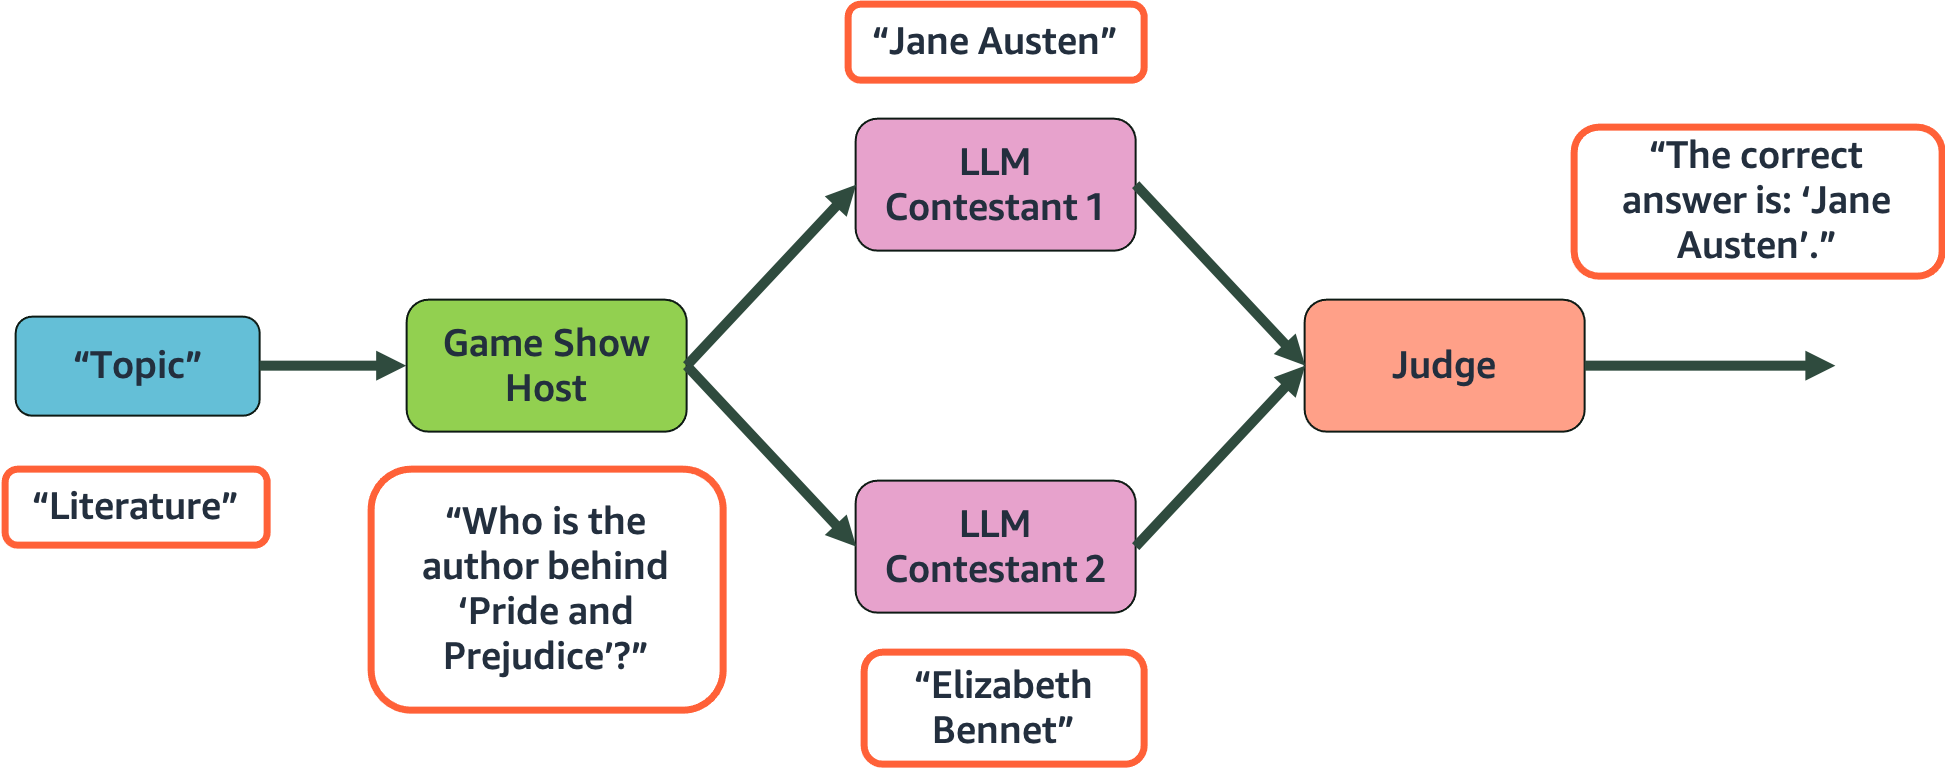
</div>



In [15]:
# Prompt template for the game_show_host_chain
game_show_host_prompt = PromptTemplate.from_template(
    """
You are a game show host. Given a topic, write a question for the contestants.

Topic: {topic}

Question:
"""
)

# Prompt template for the contestant_one_chain
contestant_one_prompt = PromptTemplate.from_template(
    """
You are a contestant for a game show. Given a question, answer the question.

Question: {question}

Answer:
"""
)

# Prompt template for the contestant_two_chain
# The prompt is intended to make contestant two answer incorrectly to test the judge chain.
contestant_two_prompt = PromptTemplate.from_template(
    """
You are a contestant for a game show.
You know very little about general topics.
Your answer to the given question is incorrect and irrelevant.
Only answer with a few words without a preamble or explaination.

Question: {question}

Answer:
"""
)

# Prompt template for the judge_chain
judge_prompt = PromptTemplate.from_template(
    """
You the judge of a contest. Given a question and two answers: Answer 1 and Answer 2, you should pick the correct answer.\
If you don't know the answer to a question you should admit that you don't know.

Question:{question}

Answer 1: {answer1}
Answer 2: {answer2}

The correct answer is:
"""
)

# Define LLMChains for each prompt template
game_show_host_chain = LLMChain(
    llm=bedrock_llm, prompt=game_show_host_prompt, output_key="question"
)
contestant_one_chain = LLMChain(
    llm=bedrock_llm, prompt=contestant_one_prompt, output_key="answer1"
)
contestant_two_chain = LLMChain(
    llm=bedrock_llm, prompt=contestant_two_prompt, output_key="answer2"
)
judge_chain = LLMChain(
    llm=bedrock_llm, prompt=judge_prompt, output_key="correct_answer"
)

# Combine the four chains using the SequentialChain
game_show_chain = SequentialChain(
    chains=[
        game_show_host_chain,
        contestant_one_chain,
        contestant_two_chain,
        judge_chain,
    ],
    input_variables=["topic"],
    output_variables=["question", "answer1", "answer2", "correct_answer"],
    verbose=True,
)

# Run the SequentialChain
game_show_response = game_show_chain("Literature")

# Format the responses in a dataframe and print
with pd.option_context("display.max_colwidth", None):
    display(pd.DataFrame.from_dict(game_show_response, orient="index"))



> Entering new SequentialChain chain...

> Finished chain.


,0
topic,Literature
question,"""In the classic novel 'To Kill a Mockingbird' by Harper Lee, who is the narrator and main character of the story?""\n\nA) Atticus Finch\nB) Scout Finch\nC) Jem Finch\nD) Boo Radley\n\nCorrect Answer: B) Scout Finch"
answer1,B) Scout Finch
answer2,\nA) Atticus Finch
correct_answer,"B) Scout Finch\n\nExplanation:\nScout Finch is the narrator and main character of the story 'To Kill a Mockingbird' by Harper Lee. She is a young girl growing up in the American South during the 1930s, and the novel follows her experiences as she navigates the complexities of race, class, and morality in her small town.\n\nAnswer 2, which suggests that Atticus Finch is the main character, is incorrect. While Atticus Finch is an important character in the novel and serves as Scout's father and moral compass, he is not the narrator or main character.\n\nTherefore, the correct answer is:\nB) Scout Finch"


---

### <a name="7">Quizzes</a>
(<a href="#0">Go to top</a>)

Well done on completing the lab! Now, it's time for a brief knowledge assessment.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="./images/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Answer the following questions to test your understanding of using pre-trained LLMs for inference.</p>
    <br>
</div>


In [16]:
from mlu_utils.quiz_questions import *

lab2_question1

In [17]:
lab2_question2

Let's restart the kernel to release CPU and GPU memory for the next lab.

**You might see a pop up indicating the kernel has been restarted.**

In [18]:
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

<p style="padding: 10px; border: 1px solid black;">
<img src="images/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>

# Thank you!